In [1]:
import os
import pandas as pd
from pymongo import MongoClient
from typing import List
import sys
if False:
    MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017/")
    DB_NAME = os.getenv("DB_NAME", "amazon_reviews")
    COLLECTION_NAME = os.getenv("COLLECTION_NAME", "reviews")
    DATA_FILE = os.path.join("data", "Reviews.csv")
    SAMPLE_SIZE = 10000  # Limit initial load to 10k rows for speed
    # Using a sample because the file is huge!
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]
    cursor = collection.find().limit(50000)

    #converting the cursor to a list of dictionaries, then to a DataFrame
    df = pd.DataFrame(list(cursor))
    df.to_csv("data.csv")
else:
    df= pd.read_csv("data.csv")
#removing the _id column that was added from mongodb
if not df.empty and '_id' in df.columns:
    df = df.drop(columns=['_id'])


print(f"Data loaded successfully from MongoDB! Total rows: {len(df)}")

Data loaded successfully from MongoDB! Total rows: 50000


In [2]:
print(df.head())

   Unnamed: 0  Id   ProductId          UserId  \
0           0   1  B001E4KFG0  A3SGXH7AUHU8GW   
1           1   2  B00813GRG4  A1D87F6ZCVE5NK   
2           2   3  B000LQOCH0   ABXLMWJIXXAIN   
3           3   4  B000UA0QIQ  A395BORC6FGVXV   
4           4   5  B006K2ZZ7K  A1UQRSCLF8GW1T   

                       ProfileName  HelpfulnessNumerator  \
0                       delmartian                     1   
1                           dll pa                     0   
2  Natalia Corres "Natalia Corres"                     1   
3                             Karl                     3   
4    Michael D. Bigham "M. Wassir"                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   
2                       1      4  1219017600  "Delight" says it all   
3                       3      2  1307923200         Cough M

In [3]:
print(df.isna().sum())
print(df.duplicated().sum())
# only small number of nulls in not important features: ProfileName, (summary is important) and no duplicates

Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64
0


In [4]:
#droping rows that have null summmary

df = df.dropna(subset=['Summary'])
print(df.isna().sum())

Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


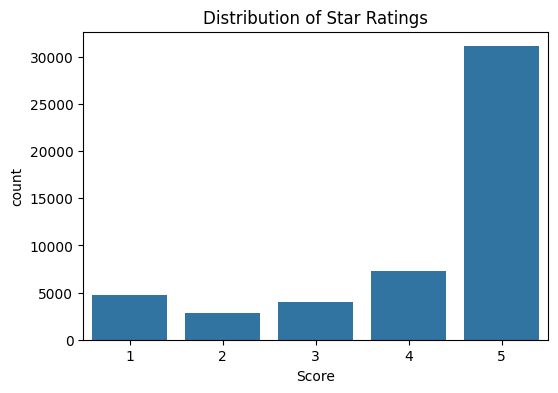

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Score', data=df)
plt.title('Distribution of Star Ratings')
plt.show()


In [6]:
#After finding that the number of five star reviews is much larger than the number of one/two/three/four star reviews, We decided to do
# down sampling to avoid model prediction laziness (1(positive review)) and get a good accuracy.

# Separate the classes, removing the reviews of score 3 as they are neutral (have both good and bad words togther)

df = df[df['Score'] != 3]

df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

min_size = df['Sentiment'].value_counts().min()

df_pos = df[df['Sentiment'] == 1].sample(n=min_size, random_state=42)
df_neg = df[df['Sentiment'] == 0].sample(n=min_size, random_state=42)

balanced_df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42)

print("Balanced Sentiment Distribution:")
print(balanced_df['Sentiment'].value_counts())

Balanced Sentiment Distribution:
Sentiment
0    7533
1    7533
Name: count, dtype: int64


In [7]:
balanced_df

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
48272,48272,48273,B004SRH2B6,ACE2UV64BSIM0,bbrown,1,1,1,1343606400,Really bad taste : (,I was expecting this to taste as good as some ...,0
46383,46383,46384,B002GJ9JWS,AJZWI84XRI4OS,Frantastic,0,0,5,1349654400,Love this stuff!,Can't go wrong with this product. I have no co...,1
9027,9027,9028,B006N3IG4K,A1PGA8C2EAUSBT,funlinesdirect,2,3,2,1287446400,Great name but I didn't care for it,I drink about 4 to 6 cups of coffee every morn...,0
39432,39432,39433,B001ELL86Y,A17V0GPCRIXRF7,Marc R Recasino,2,2,1,1317340800,k-cup package,The coffee package leeks out all over machine ...,0
49025,49025,49026,B007S0FZY6,A2FP1XVV2QTOCO,gumguy6667,1,1,2,1337126400,Fruity fresh? More like Fruity LAME,"<span class=""tiny""> Length:: 1:02 Mins<br /><b...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
27905,27905,27906,B0015G862M,AJV2QY96IVPVM,SuperFids,0,0,5,1247443200,Great product for traveling with your dog!,"My dog is on a raw diet, which makes travel so...",1
35065,35065,35066,B002DLXXHG,A2AXRD9IOU4UIH,"bargainhunter ""amazingbargains""",2,3,1,1270425600,Must be your first time trying jerky if you le...,Let me say this first: our family of 6 keeps ...,0
24924,24924,24925,B0078Y6OX8,AL7N0L8AI7NH3,Pete,0,0,5,1288742400,Best Flavor - Super Convenient,"Of all the K-Cup flavors we've brewed, this is...",1
29572,29572,29573,B000PDY3P0,A3KTVXSMCWP0XQ,Harv Walton,0,1,4,1240617600,Easy popcorn,I'm happy to say that in this case a pretty pa...,1


C:\Users\dhamd\AppData\Local\Temp\ipykernel_22444\4287812407.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, ax=ax[0], palette='Reds_r')
C:\Users\dhamd\AppData\Local\Temp\ipykernel_22444\4287812407.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=balanced_df, ax=ax[1], palette='Blues')


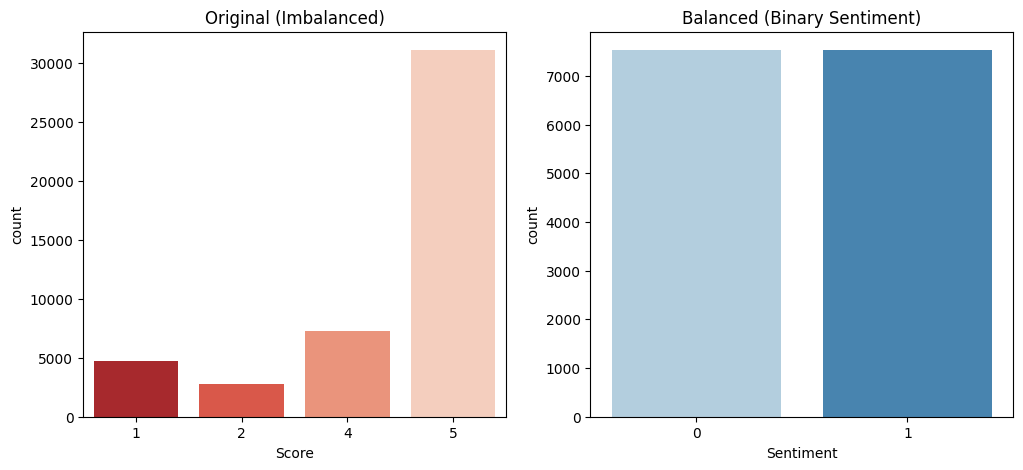

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before
sns.countplot(x='Score', data=df, ax=ax[0], palette='Reds_r')
ax[0].set_title('Original (Imbalanced)')

# After
sns.countplot(x='Sentiment', data=balanced_df, ax=ax[1], palette='Blues')
ax[1].set_title('Balanced (Binary Sentiment)')

plt.show()

In [9]:
# for our dataset, it is not a good practice to use features like Id, ProductId, UserId, ProfileName, , Time as they are not something that a user enters
# and for example the same user can do both positive and negative reviews
# Also HelpfulnessNumerator,	HelpfulnessDenominator can't be an indicator of positive or negative review
# But Summary and text features are good indicators for a positive or negative review, as summary can be concise and text are more detailed.
# So we decided to drop Id, ProductId, UserId, ProfileName, , Time, HelpfulnessNumerator,	HelpfulnessDenominator and combine summary and text features

balanced_df['Combined_Content'] = balanced_df['Summary'] + " " + balanced_df['Text']

final_balanced_df = balanced_df[['Combined_Content', 'Sentiment']].copy()

print("Columns remaining:", final_balanced_df.columns.tolist())
print(final_balanced_df.head())



Columns remaining: ['Combined_Content', 'Sentiment']
                                        Combined_Content  Sentiment
48272  Really bad taste  : ( I was expecting this to ...          0
46383  Love this stuff! Can't go wrong with this prod...          1
9027   Great name but I didn't care for it I drink ab...          0
39432  k-cup package The coffee package leeks out all...          0
49025  Fruity fresh?  More like Fruity LAME <span cla...          0


In [10]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# removing the links, doing lowercase, and removing the stopwords
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]

    return " ".join(words)

final_balanced_df['Cleaned_content'] = final_balanced_df['Combined_Content'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhamd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
print(final_balanced_df[['Cleaned_content','Sentiment']])

                                         Cleaned_content  Sentiment
48272  really bad taste expecting taste good coconut ...          0
46383  love stuff go wrong product complaints helps p...          1
9027   great name care drink cups coffee every mornin...          0
39432  k cup package coffee package leeks machine wia...          0
49025          fruity fresh like fruity lame length mins          0
...                                                  ...        ...
27905  great product traveling dog dog raw diet makes...          1
35065  must first time trying jerky left good review ...          0
24924  best flavor super convenient k cup flavors bre...          1
29572  easy popcorn happy say case pretty package equ...          1
24695  dog favorite treat dog loves sweet potatoes sw...          1

[15066 rows x 2 columns]


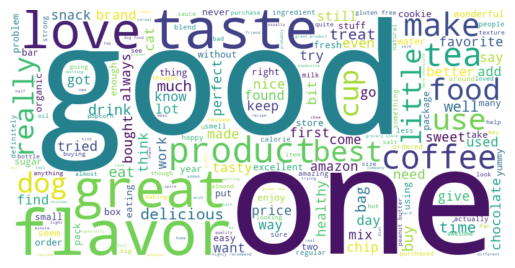

In [12]:
from wordcloud import WordCloud

#combine all text shown in the positive reviews
positive_text = " ".join(final_balanced_df[final_balanced_df['Sentiment'] == 1]['Cleaned_content'])

# Generate cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_image = wordcloud.to_image()

# Now plot the image object instead of the wordcloud object
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis("off")
plt.show()


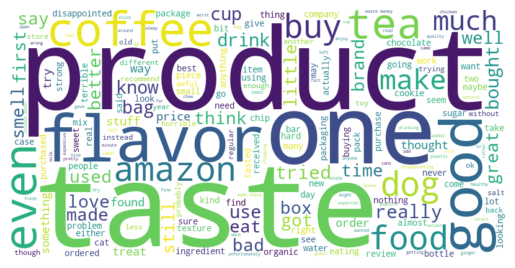

In [13]:

# combine all texts shown in the negative reviews
negative_text = " ".join(final_balanced_df[final_balanced_df['Sentiment'] == 0]['Cleaned_content'])

# Generate cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

wordcloud_image = wordcloud.to_image()

# Now plot the image object instead of the wordcloud object
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()


def apply_lemmatization(text):
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(w, pos='v') for w in words]

    return " ".join(lemmatized)

final_balanced_df['Cleaned_content'] = final_balanced_df['Cleaned_content'].apply(apply_lemmatization)
print(final_balanced_df['Cleaned_content'].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhamd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dhamd\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


48272    really bad taste expect taste good coconut wat...
46383    love stuff go wrong product complaints help pe...
9027     great name care drink cup coffee every morning...
39432    k cup package coffee package leeks machine wia...
49025            fruity fresh like fruity lame length mins
Name: Cleaned_content, dtype: object


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))


X = tfidf.fit_transform(final_balanced_df['Cleaned_content'])

y = final_balanced_df['Sentiment']

print(f"Vectorization complete! Matrix shape: {X.shape}")

Vectorization complete! Matrix shape: (15066, 10000)


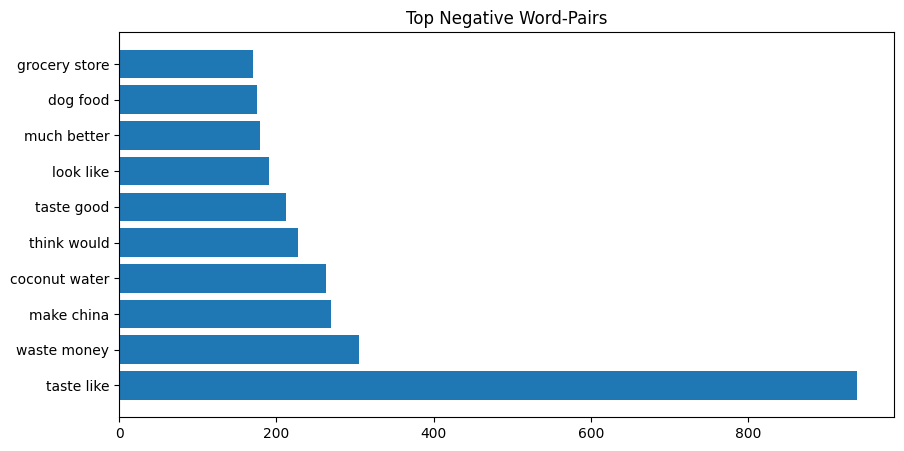

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(text, title, n=2):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]

    words, counts = zip(*words_freq)
    plt.barh(words, counts)
    plt.title(title)

plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==0]['Cleaned_content'], "Top Negative Word-Pairs")
plt.show()

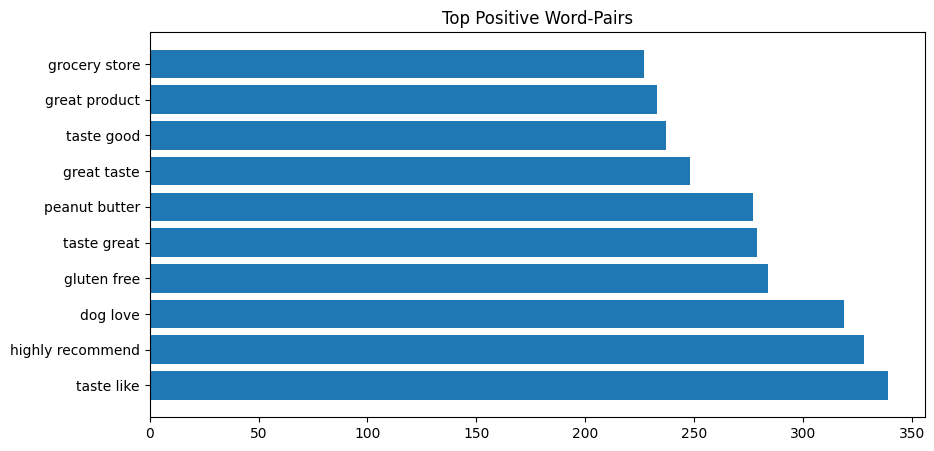

In [17]:

plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==1]['Cleaned_content'], "Top Positive Word-Pairs")
plt.show()

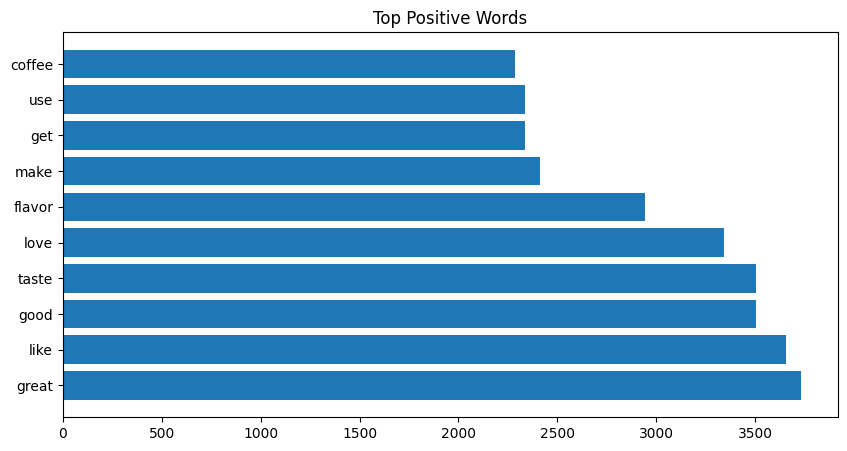

In [18]:
plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==1]['Cleaned_content'], "Top Positive Words",1)
plt.show()

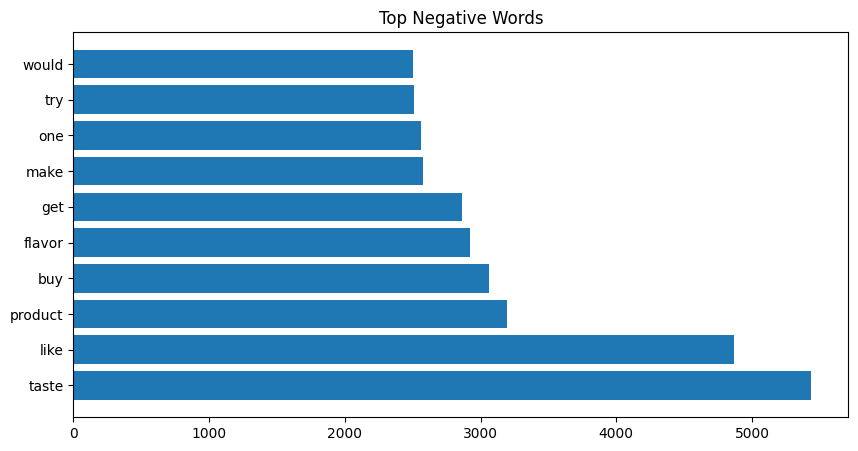

In [19]:
plt.figure(figsize=(10,5))
plot_top_ngrams(final_balanced_df[final_balanced_df['Sentiment']==0]['Cleaned_content'], "Top Negative Words",1)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("="*60)
print("DATASET SPLIT")
print("="*60)
print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")


DATASET SPLIT
Train size: (12052, 10000)
Test size: (3014, 10000)


In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


MODEL 1: LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1507
           1       0.90      0.88      0.89      1507

    accuracy                           0.89      3014
   macro avg       0.89      0.89      0.89      3014
weighted avg       0.89      0.89      0.89      3014



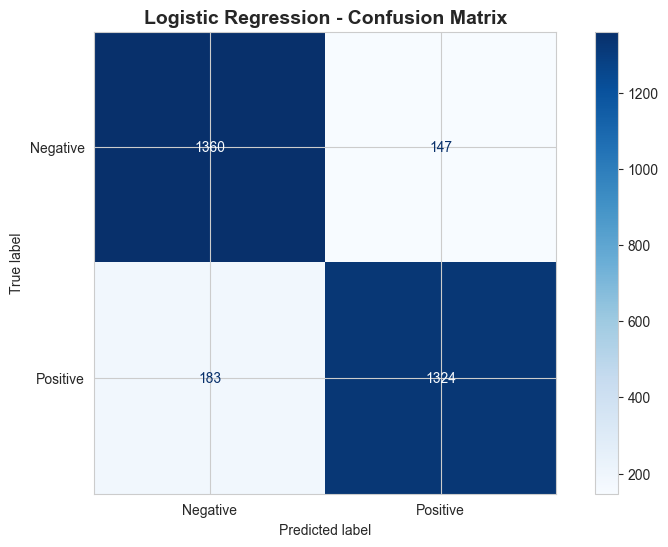

In [22]:
print("MODEL 1: LOGISTIC REGRESSION")
print("="*60)

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['Negative', 'Positive'])
disp_lr.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix", fontsize=14, fontweight='bold')
plt.show()


MODEL 2: NAIVE BAYES
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1507
           1       0.89      0.88      0.88      1507

    accuracy                           0.88      3014
   macro avg       0.88      0.88      0.88      3014
weighted avg       0.88      0.88      0.88      3014



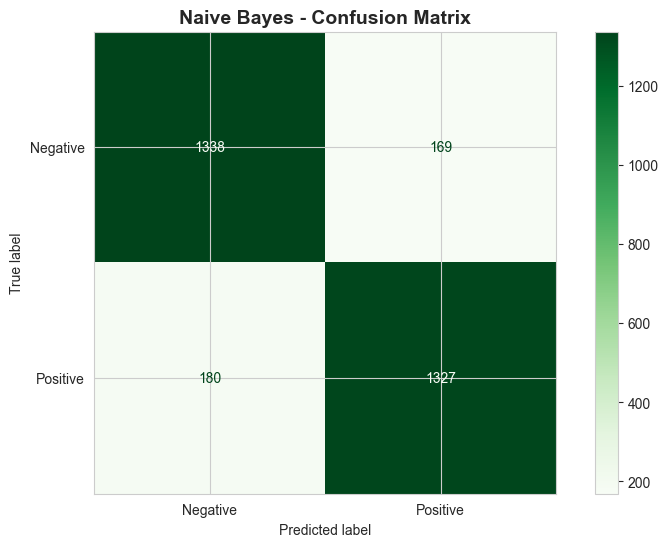

In [23]:
print("MODEL 2: NAIVE BAYES")
print("="*60)

nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=['Negative', 'Positive'])
disp_nb.plot(cmap='Greens')
plt.title("Naive Bayes - Confusion Matrix", fontsize=14, fontweight='bold')
plt.show()



MODEL 3: DECISION TREE
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1507
           1       0.77      0.77      0.77      1507

    accuracy                           0.77      3014
   macro avg       0.77      0.77      0.77      3014
weighted avg       0.77      0.77      0.77      3014



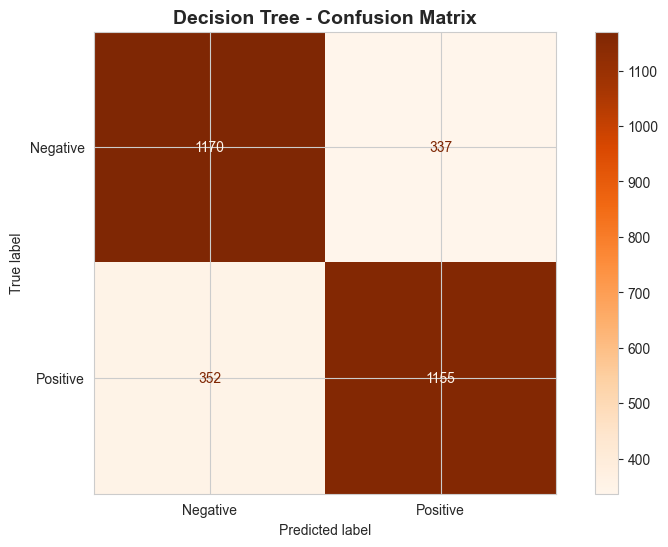

In [26]:
print("MODEL 3: DECISION TREE")
print("="*60)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(cm_dt, display_labels=['Negative', 'Positive'])
disp_dt.plot(cmap='Oranges')
plt.title("Decision Tree - Confusion Matrix", fontsize=14, fontweight='bold')
plt.show()


MODEL 4: K-NEAREST NEIGHBORS
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1507
           1       0.73      0.74      0.74      1507

    accuracy                           0.74      3014
   macro avg       0.74      0.74      0.74      3014
weighted avg       0.74      0.74      0.74      3014



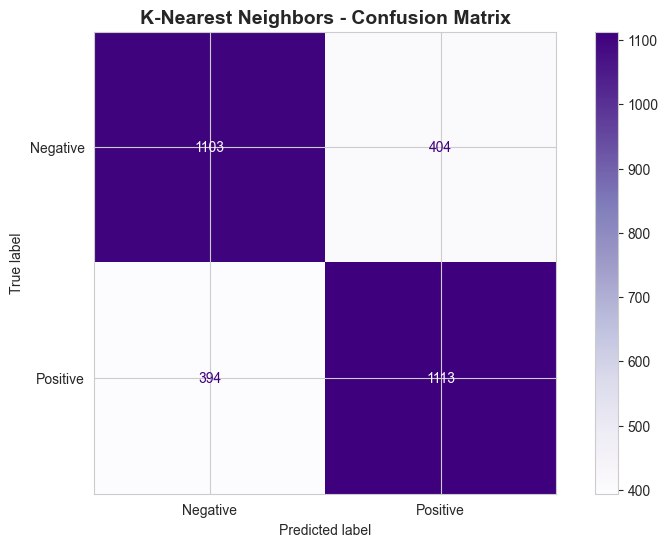

In [24]:
print("MODEL 4: K-NEAREST NEIGHBORS")
print("="*60)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(cm_knn, display_labels=['Negative', 'Positive'])
disp_knn.plot(cmap='Purples')
plt.title("K-Nearest Neighbors - Confusion Matrix", fontsize=14, fontweight='bold')
plt.show()


In [27]:
print("MODEL COMPARISON (BEFORE TUNING)")
print("="*60)

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes", "Decision Tree", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_knn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_nb),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_knn)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_nb),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_knn)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_nb),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_knn)
    ]
})

print(results.round(4))
print()


MODEL COMPARISON (BEFORE TUNING)
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.8905     0.9001  0.8786    0.8892
1          Naive Bayes    0.8842     0.8870  0.8806    0.8838
2        Decision Tree    0.7714     0.7741  0.7664    0.7703
3                  KNN    0.7352     0.7337  0.7386    0.7361



In [29]:
print("HYPERPARAMETER TUNING - GRIDSEARCH")
print("="*60)

# ---- Logistic Regression ----
print("\n Tuning Logistic Regression...")
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ['l2'],
    "solver": ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid_lr.fit(X_train, y_train)

print(f" Best Parameters: {grid_lr.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_lr.best_score_:.4f}")
print(f" Test Accuracy: {grid_lr.score(X_test, y_test):.4f}\n")



HYPERPARAMETER TUNING - GRIDSEARCH

 Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8927
 Test Accuracy: 0.9001



In [30]:
print("Tuning Naive Bayes...")
param_grid_nb = {
    "alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

grid_nb = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=5,
    scoring="accuracy",
    verbose=1
)
grid_nb.fit(X_train, y_train)

print(f"Best Parameters: {grid_nb.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_nb.best_score_:.4f}")
print(f"Test Accuracy: {grid_nb.score(X_test, y_test):.4f}\n")



Tuning Naive Bayes...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'alpha': 1.0}
Best Cross-Validation Accuracy: 0.8837
Test Accuracy: 0.8842



In [31]:
print("Tuning Decision Tree...")
param_grid_dt = {
    "max_depth": [10, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ['gini', 'entropy']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid_dt.fit(X_train, y_train)

print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_dt.best_score_:.4f}")
print(f"Test Accuracy: {grid_dt.score(X_test, y_test):.4f}\n")


Tuning Decision Tree...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.7699
Test Accuracy: 0.7850



In [33]:
print("Tuning K-Nearest Neighbors...")
param_grid_knn = {
    "n_neighbors": [3, 7, 15],
    "metric": ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid_knn,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid_knn.fit(X_train, y_train)

print(f"Best Parameters: {grid_knn.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_knn.best_score_:.4f}")
print(f"Test Accuracy: {grid_knn.score(X_test, y_test):.4f}\n")


Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 15}
Best Cross-Validation Accuracy: 0.7601
Test Accuracy: 0.7621



In [34]:
print("TUNED MODELS - FINAL EVALUATION")
print("="*60)

best_lr = grid_lr.best_estimator_
best_nb = grid_nb.best_estimator_
best_dt = grid_dt.best_estimator_
best_knn = grid_knn.best_estimator_

y_pred_best_lr = best_lr.predict(X_test)
y_pred_best_nb = best_nb.predict(X_test)
y_pred_best_dt = best_dt.predict(X_test)
y_pred_best_knn = best_knn.predict(X_test)

tuned_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes", "Decision Tree", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_best_lr),
        accuracy_score(y_test, y_pred_best_nb),
        accuracy_score(y_test, y_pred_best_dt),
        accuracy_score(y_test, y_pred_best_knn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_best_lr),
        precision_score(y_test, y_pred_best_nb),
        precision_score(y_test, y_pred_best_dt),
        precision_score(y_test, y_pred_best_knn)
    ],
    "Recall": [
        recall_score(y_test, y_pred_best_lr),
        recall_score(y_test, y_pred_best_nb),
        recall_score(y_test, y_pred_best_dt),
        recall_score(y_test, y_pred_best_knn)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_best_lr),
        f1_score(y_test, y_pred_best_nb),
        f1_score(y_test, y_pred_best_dt),
        f1_score(y_test, y_pred_best_knn)
    ]
})

print(tuned_results.round(4))


TUNED MODELS - FINAL EVALUATION
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.9001     0.9113  0.8865    0.8988
1          Naive Bayes    0.8842     0.8870  0.8806    0.8838
2        Decision Tree    0.7850     0.8070  0.7492    0.7770
3                  KNN    0.7621     0.7503  0.7857    0.7676


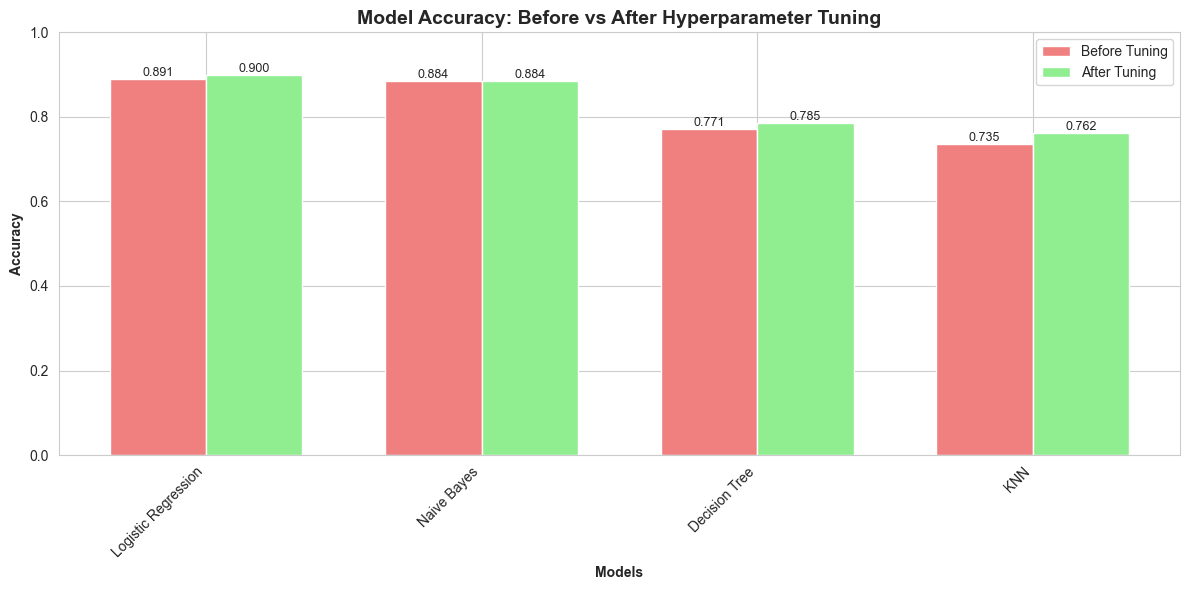

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results["Model"]))
width = 0.35

bars1 = ax.bar(x - width/2, results["Accuracy"], width, label='Before Tuning', color='lightcoral')
bars2 = ax.bar(x + width/2, tuned_results["Accuracy"], width, label='After Tuning', color='lightgreen')

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Model Accuracy: Before vs After Hyperparameter Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results["Model"], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


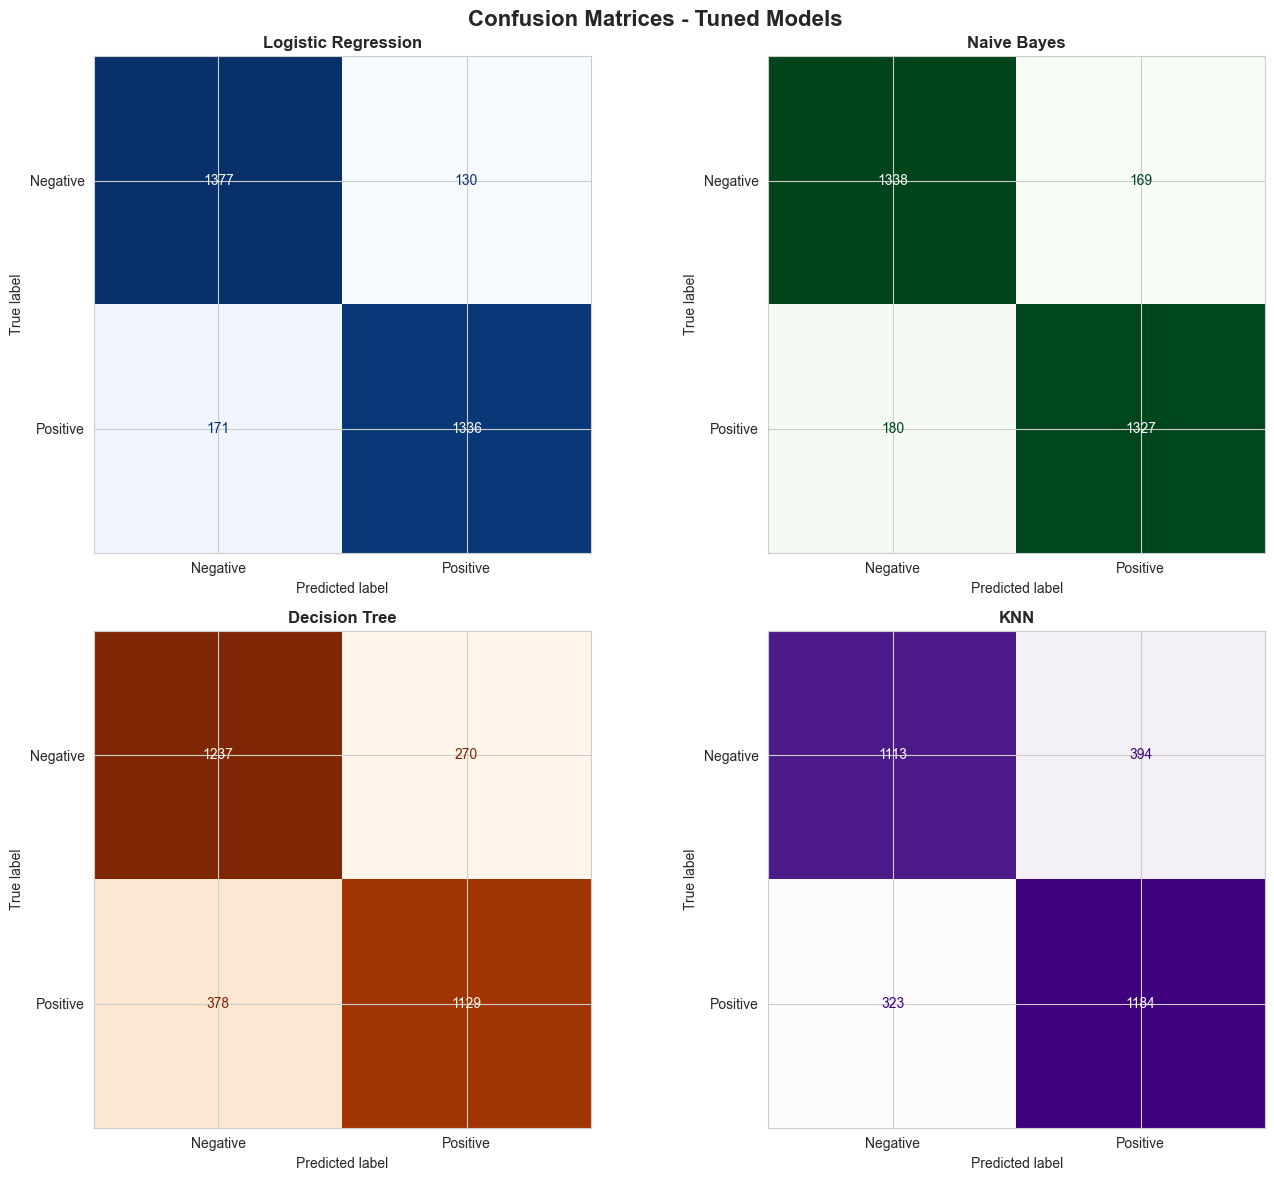

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - Tuned Models', fontsize=16, fontweight='bold')

cms = [
    (confusion_matrix(y_test, y_pred_best_lr), "Logistic Regression", 'Blues'),
    (confusion_matrix(y_test, y_pred_best_nb), "Naive Bayes", 'Greens'),
    (confusion_matrix(y_test, y_pred_best_dt), "Decision Tree", 'Oranges'),
    (confusion_matrix(y_test, y_pred_best_knn), "KNN", 'Purples')
]

for idx, (cm, title, cmap) in enumerate(cms):
    ax = axes[idx // 2, idx % 2]
    disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
    disp.plot(ax=ax, cmap=cmap, colorbar=False)
    ax.set_title(title, fontweight='bold')

plt.tight_layout()
plt.show()


In [39]:
print("="*60)
print("ERROR ANALYSIS - MISCLASSIFIED REVIEWS")
print("="*60)

# Using best model (highest accuracy)
best_model_name = tuned_results.loc[tuned_results['Accuracy'].idxmax(), 'Model']
print(f"Best Model: {best_model_name}\n")

# Get misclassified samples (using Logistic Regression as example)
test_df = final_balanced_df.loc[y_test.index].copy()
test_df["Predicted"] = y_pred_best_lr
test_df["Actual"] = y_test.values

misclassified = test_df[test_df["Predicted"] != test_df["Actual"]]

print(f"Total Misclassified: {len(misclassified)} out of {len(y_test)}")
print(f"Misclassification Rate: {len(misclassified)/len(y_test)*100:.2f}%\n")

print("Sample Misclassified Reviews:")
print(misclassified[["Cleaned_content", "Actual", "Predicted"]].head(10))



ERROR ANALYSIS - MISCLASSIFIED REVIEWS
Best Model: Logistic Regression

Total Misclassified: 301 out of 3014
Misclassification Rate: 9.99%

Sample Misclassified Reviews:
                                         Cleaned_content  Actual  Predicted
9495   return keep raise price product great remain k...       0          1
16831  sweet quench thirst find product sweet syrupy ...       0          1
20226  zuma love treat zuma hairless chinese crest pu...       1          0
34528  okay favorite still process narrow personal pr...       1          0
7895   nice tree rest tree nice part besides pot come...       0          1
6124   flamingo ship prompt package excellent items o...       0          1
16194  exactly expect like jar little cheaper plastic...       1          0
12377  taste great expensive love taste great get loc...       0          1
13810  lemon zest little oh baby use lemon zest lot b...       1          0
18351  rat okay jump gun send review information rece...       1      

In [40]:
import joblib

best_overall_model = grid_lr.best_estimator_  # Change based on best performer
joblib.dump(best_overall_model, "best_sentiment_model.pkl")
print("\n✅ Best model saved as 'best_sentiment_model.pkl'")


✅ Best model saved as 'best_sentiment_model.pkl'
